# Anonymization of PDF Documents

In this notebook, we demonstrate how **deep**doctection can be used to anonymize a PDF document in a way that makes the anonymization **irreversible**.

For anonymization, we use a **token classification model** from the Hugging Face Hub, which we integrate into our pipeline.

We proceed as follows:

* Extract text from the PDF **text layer**. If the PDF has no text layer, **OCR** can be used instead.
* Run token classification with `tanaos/tanaos-text-anonymizer-v1`.
* Mask the identified entities. For this, we convert each page into a **NumPy array**.
* Quality assurance: unmask tokens that were masked **by mistake** (false positives).
* Convert the NumPy arrays back into an anonymized PDF by embedding them as images.

In [1]:
import numpy as np
from io import BytesIO

import deepdoctection as dd
from dd_core.utils.viz import interactive_imshow
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

We first start to register the PII-Information that the model is supposed to predict.

We also need to register the model itself, so that we can invoke it directly in a **deep**doctection pipeline.

**Note**: Once you search for `pii` or `anonymisation` on the Huggingface Hub, you get hundreds of matches. We have opted for one popular representative but it is likely that there are other models that might perform better on some particular use-case. 

In [2]:
@dd.object_types_registry.register("PIITypes")
class PIITypes(dd.ObjectTypes):

    B_PERSON ="b_person"
    I_PERSON = "i_person"
    B_LOCATION = "b_location"
    I_LOCATION = "i_location"
    B_DATE = "b_date"
    I_DATE = "i_date"
    B_ADDRESS = "b_address"
    I_ADDRESS = "i_adress"
    B_PHONE_NUMBER = "b_phone_number"
    I_PHONE_NUMBER = "i_phone_number"


dd.ModelCatalog.register("tanaos/tanaos-text-anonymizer-v1/model.safetensors", dd.ModelProfile(
    name="tanaos/tanaos-text-anonymizer-v1/model.safetensors",
    description="layout detection ",
    config="tanaos/tanaos-text-anonymizer-v1/config.json",
    hf_repo_id="tanaos/tanaos-text-anonymizer-v1",
    hf_config_file=["special_tokens_map.json","tokenizer_config.json","tokenizer.json","config.json"],
    hf_model_name="model.safetensors",
    size=[3334322],
    categories={1: dd.TokenClasses.OTHER,
                2: PIITypes.B_PERSON,
                3: PIITypes.I_PERSON,
                4: PIITypes.B_LOCATION,
                5: PIITypes.I_LOCATION,
                6: PIITypes.B_DATE,
                7: PIITypes.I_DATE,
                8: PIITypes.B_ADDRESS,
                9: PIITypes.I_ADDRESS,
                10: PIITypes.B_PHONE_NUMBER,
                11: PIITypes.I_PHONE_NUMBER},
    model_wrapper="HFLmTokenClassifier",
))

We also add some layout sections to the narrative text so that they can be analyzed by the token classifier.

In [3]:
dd.IMAGE_DEFAULTS.FLOATING_TEXT_BLOCK_CATEGORIES = (dd.LayoutType.TEXT,
            dd.LayoutType.TITLE,
            dd.LayoutType.LIST,
            dd.LayoutType.KEY_VALUE_AREA,
            dd.LayoutType.TABLE)

Next we write some functions for masking/unmasking words and converting a list of images into a PDF

In [4]:
def blacken_bboxes(np_image, bboxes):
    """
    Deepdoctection guarantees: uint8, BGR, shape (H, W, 3).
    bboxes are absolute xyxy coords: [ulx, uly, lrx, lry].
    """
    img = np.array(np_image, copy=True)
    h, w = img.shape[:2]

    for x1, y1, x2, y2 in bboxes:
        x1i = int(np.floor(min(x1, x2)))
        y1i = int(np.floor(min(y1, y2)))
        x2i = int(np.ceil(max(x1, x2)))
        y2i = int(np.ceil(max(y1, y2)))

        x1i = max(0, min(w, x1i))
        y1i = max(0, min(h, y1i))
        x2i = max(0, min(w, x2i))
        y2i = max(0, min(h, y2i))

        if x2i > x1i and y2i > y1i:
            img[y1i:y2i, x1i:x2i, :] = 0

    return img

def unblacken_bbox(page, masked_img, words, image_id):
    """
    Paste word crops back into their original positions on a masked page image.

    Assumptions (as per your constraints):
      - np_image_bgr: uint8 BGR, shape (H, W, 3)
      - word.bounding_box exists with ulx/uly/lrx/lry and absolute_coords
      - word.image.image returns uint8 BGR crop
    """
    out = np.array(masked_img, copy=True)
    H, W = out.shape[:2]

    for word in words:
        bbox = word.get_bounding_box(image_id).transform(image_width=W,image_height=H,absolute_coords=True)
        x0, y0, x1, y1 = bbox.ulx, bbox.uly, bbox.lrx, bbox.lry

        x0i = max(0, min(W, int(np.floor(min(x0, x1)))))
        y0i = max(0, min(H, int(np.floor(min(y0, y1)))))
        x1i = max(0, min(W, int(np.ceil(max(x0, x1)))))
        y1i = max(0, min(H, int(np.ceil(max(y0, y1)))))

        if word.np_image is None:
            page.base_image.image_ann_to_image(annotation_id=word.annotation_id, crop_image=True)
        patch = word.np_image  # BGR uint8 crop
        th, tw = (y1i - y0i), (x1i - x0i)

        # Resize via deepdoctection's handler (PIL/CV2 behind the scenes) :contentReference[oaicite:1]{index=1}
        if patch.shape[0] != th or patch.shape[1] != tw:
            patch = dd.viz_handler.resize(patch, width=tw, height=th, interpolation="VIZ")

        out[y0i:y1i, x0i:x1i, :] = patch

    return out

def images_to_pdf(masked_images, out_pdf_path, dpi: int = 300):
    """
    Write a sequence of deepdoctection images (uint8 BGR) as an image-only multi-page PDF.
    Uses dd.viz_handler.encode() (PNG) to avoid manual BGR->RGB conversions. :contentReference[oaicite:2]{index=2}
    """
    if not masked_images:
        raise ValueError("masked_images_bgr is empty")

    c = None
    for img_bgr in masked_images:
        h_px, w_px = img_bgr.shape[:2]
        w_pt = (w_px / dpi) * 72.0
        h_pt = (h_px / dpi) * 72.0

        if c is None:
            c = canvas.Canvas(out_pdf_path, pagesize=(w_pt, h_pt))
        else:
            c.setPageSize((w_pt, h_pt))

        png_bytes = dd.viz_handler.encode(img_bgr)  # PNG bytes :contentReference[oaicite:3]{index=3}
        img_reader = ImageReader(BytesIO(png_bytes))
        c.drawImage(img_reader, 0, 0, width=w_pt, height=h_pt, mask=None)
        c.showPage()

    c.save()

We instantiate the **deep**doctection analyzer and add the freshly registered model. 
The model has a context window of 512 token. As one page can contain more than 512 token, we activate the sliding window approach with a stride of 64 token.

In [ ]:
analyzer = dd.get_dd_analyzer(
        config_overwrite=["USE_LM_TOKEN_CLASS=True",
                          "USE_OCR=False",
                          "USE_PDF_MINER=True",
                          "LM_TOKEN_CLASS.WEIGHTS=tanaos/tanaos-text-anonymizer-v1/model.safetensors",
                          "LM_TOKEN_CLASS.SLIDING_WINDOW_STRIDE=64"])

df = analyzer.analyze(path ="/path/to/dir/some.pdf",
                      max_datapoints=3)
df.reset_state()

Now, we start processing the document.

In [ ]:
pages = list(df)
pages_iter = iter(pages)
masked_images = []

Now comes the redaction part. We select all words with `token_class!="other"` and masks these words with `blacken_bboxes`. 

In [7]:
page = next(pages_iter)

print(f"page_number: {page.page_number}")
masked_boxes = []
for word in page.words:
    if word.token_class !="other":
        print(f"masking word: {word.characters}, token_class: {word.token_class}, annotation_id: {word.annotation_id}")
        masked_boxes.append(page._ann_viz_bbox(word))
masked_img = blacken_bboxes(page.base_image.image, masked_boxes)

page_number: 0
masking word: Jahresbericht, token_class: b_date, annotation_id: ed7ab670-8900-31ca-95fe-95b00fd5a2d2
masking word: 31., token_class: b_date, annotation_id: c895b903-c2cb-3216-843b-2b5c84a1f4f7
masking word: Dezember, token_class: b_date, annotation_id: 787ecd82-cbd3-3196-b93e-ca6b48896b00
masking word: 2018, token_class: b_date, annotation_id: 3362d9af-fc5b-31d0-9be5-857a40d5b34a
masking word: CIC, token_class: b_location, annotation_id: f9e31046-6159-393d-bf4a-5310370632c6
masking word: CH, token_class: b_location, annotation_id: bd3e6506-da24-372f-9751-9757ec9c07ed
masking word: Kapital, token_class: b_location, annotation_id: afa7aae4-1f26-392c-b860-35be142c18f8
masking word: luxemburgischen, token_class: b_location, annotation_id: 8f2ddb79-7751-3673-ae5e-6aaad9dc54db
masking word: Rechts, token_class: b_location, annotation_id: e88be192-ac8b-38a0-be4d-fcaf6643277e
masking word: Teilfonds, token_class: b_location, annotation_id: 962a40a6-f761-3af0-85af-6fb15116f0b9
m

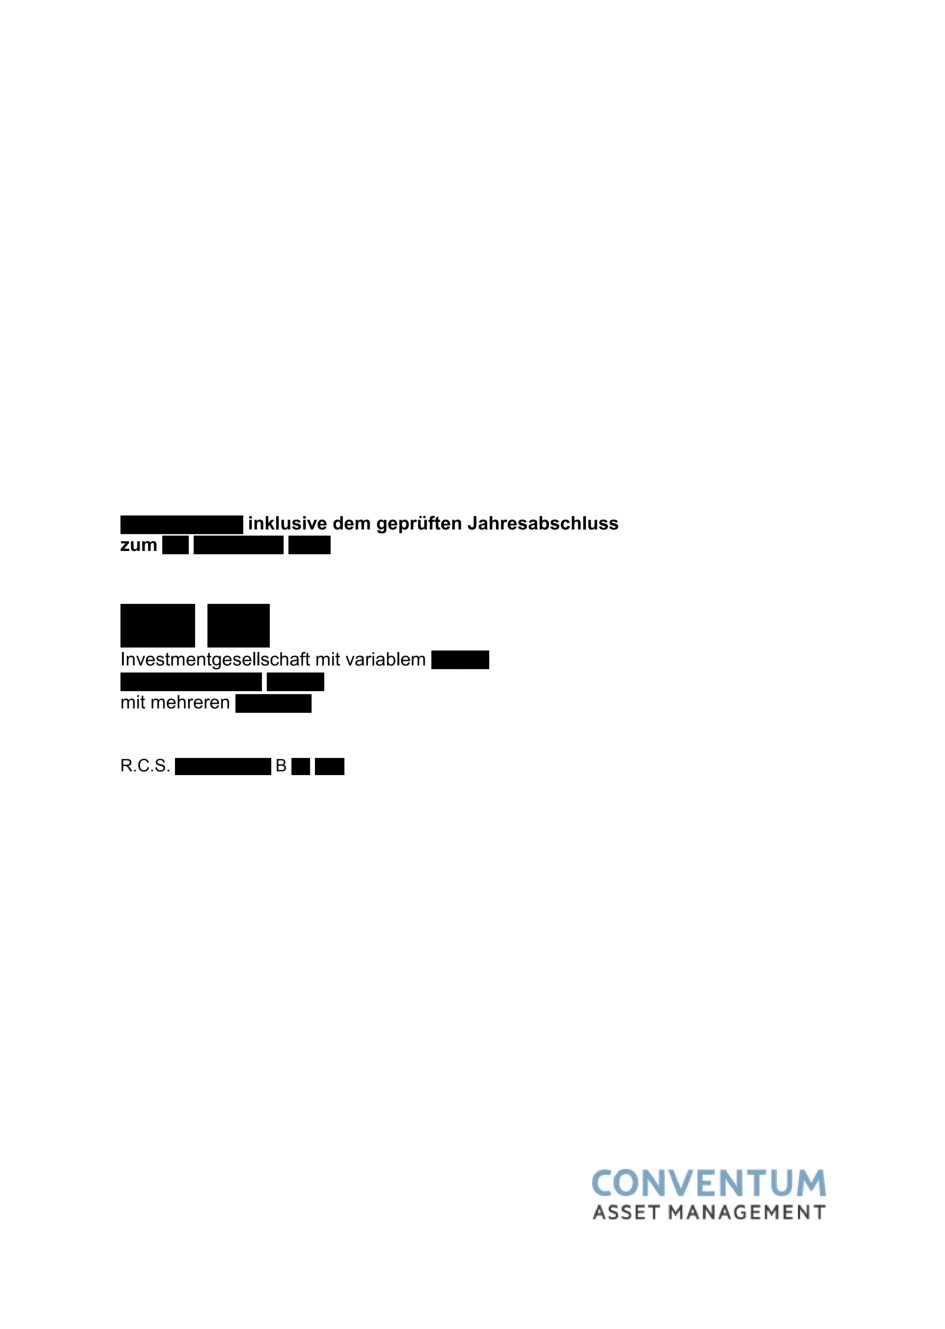

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(masked_img)

Suppose, we want to un-do the masking of the following line:

```
masking word: Jahresbericht, token_class: b_date, annotation_id: ed7ab670-8900-31ca-95fe-95b00fd5a2d2
```

We retrieve the metadata and paste the original pixel values into the black rectangle. 

In [9]:
words = page.get_annotation(annotation_ids="ed7ab670-8900-31ca-95fe-95b00fd5a2d2")

In [10]:
masked_img = unblacken_bbox(page, masked_img, words, page.image_id)

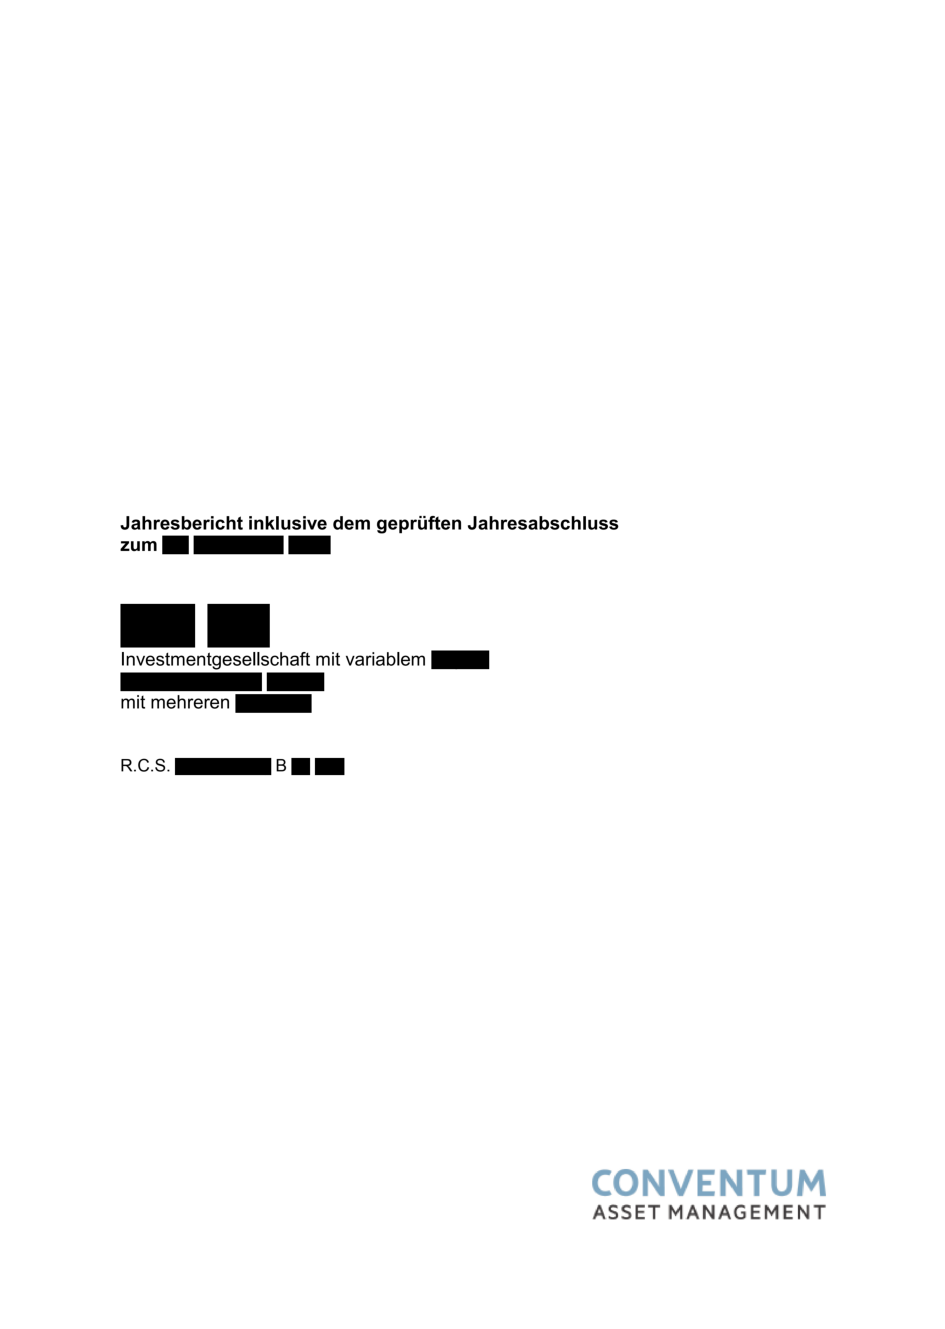

In [11]:
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(masked_img)

In [12]:
masked_images.append(masked_img)

We can go back to back to cell `[7]` and process the next page in the same way. 

Once finish, we save all redacted pages as image embeddings in a PDF. As we have a high resolution of DPI=200 the resulting PDF will certainly be larger than the original. Reducing the `DPI` will also reduce the file size.

In [17]:
images_to_pdf(masked_images,"/path/to/dir/some_redacted.pdf",dpi=200)